# Clustering Unlabeled Sound Data

## Assignment

Complete the tasks in the notebook and document your observations in the markdown cells.

In [ ]:
#Make allNecessary Imports
import pandas as pd
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN # Import DBSCAN
from sklearn.preprocessing import StandardScaler # Import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score # Import clustering evaluation metrics
from sklearn.cluster import KMeans # Import KMeans

Import zipfile from drive

In [54]:
from google.colab import drive
drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/ALU/datasets/unlablled_sounds.zip'
#unzip file

!unzip -q "/content/drive/MyDrive/ALU/datasets/unlabelled_sounds.zip" -d "/content/unlabelled_sounds"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
replace /content/unlabelled_sounds/unlabelled_sounds/3.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/unlabelled_sounds/unlabelled_sounds/4.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/unlabelled_sounds/unlabelled_sounds/10.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [55]:
# Load the Data
unlabelled_data_path = '/content/unlabelled_sounds/unlabelled_sounds'

wav_files = [os.path.join(unlabelled_data_path, f) for f in os.listdir(unlabelled_data_path) if f.endswith('.wav')]
features = []
file_names = []

def extract_features(file_path):
    try:
        y, sr = librosa.load(file_path, sr=None)

        if len(y) < 1024:
            return None  # Skip short files

        n_fft = 1024  # Consistent FFT window size

        # Mel Spectrogram
        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, n_fft=n_fft)
        mel_db = librosa.power_to_db(mel, ref=np.max)

        # Mel stats
        mel_stats = np.hstack([
            np.mean(mel_db, axis=1),
            np.std(mel_db, axis=1),
            np.max(mel_db, axis=1),
            np.min(mel_db, axis=1)
        ])

        # Spectral features with explicit n_fft
        zcr = librosa.feature.zero_crossing_rate(y)
        centroid = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=n_fft)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=n_fft)

        spectral_stats = np.array([
            np.mean(zcr), np.std(zcr),
            np.mean(centroid), np.std(centroid),
            np.mean(rolloff), np.std(rolloff)
        ])

        return np.hstack((mel_stats, spectral_stats))

    except Exception as e:
        print(f"Failed on {file_path}: {e}")
        return None

# Process files
for path in tqdm(wav_files, desc="Extracting"):
    feats = extract_features(path)
    if feats is not None:
        features.append(feats)
        file_names.append(os.path.basename(path))

# Build DataFrame
features = np.array(features)
features_df = pd.DataFrame(features)
features_df.insert(0, 'filename', file_names)

# Normalize features (excluding filename)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_df.iloc[:, 1:])

print("\n✅ Feature extraction complete!")
print("Shape of feature matrix:", features_scaled.shape)
print("Sample features:")
display(features_df.head())

Extracting:   0%|          | 0/3000 [00:00<?, ?it/s]


✅ Feature extraction complete!
Shape of feature matrix: (3000, 518)
Sample features:


,filename,0,1,2,3,4,5,6,7,8,...,508,509,510,511,512,513,514,515,516,517
0,327.wav,-16.632410,-36.456512,-36.533276,-38.400593,-33.119839,-19.609243,-17.112162,-22.388777,-26.551476,...,-31.756039,-31.556242,-34.935341,-32.817757,0.192220,0.030782,1309.580662,363.891220,3062.500000,366.522003
1,1320.wav,-53.273376,-49.825851,-48.905849,-52.154205,-42.826729,-31.686119,-31.173649,-40.735229,-43.872147,...,-64.318382,-63.850918,-65.714569,-65.348083,0.159125,0.058202,1123.286454,212.175732,2429.687500,806.097908
2,78.wav,-23.982847,-41.364407,-42.718586,-45.777416,-38.634449,-25.554350,-21.832266,-22.604120,-28.048828,...,-40.194508,-40.707760,-39.947842,-40.631226,0.141113,0.028821,1225.981133,285.202827,2717.447917,691.386633
3,1240.wav,-51.652515,-49.374737,-47.992603,-47.454800,-43.945011,-36.890503,-31.129429,-28.095934,-27.068686,...,-57.501717,-57.630089,-55.993496,-57.140095,0.171387,0.093227,1106.442733,714.349798,1956.473214,1189.707015
4,2565.wav,-22.072689,-37.826450,-38.111504,-37.622856,-39.318859,-25.593485,-14.094788,-13.262415,-23.118629,...,-40.216972,-41.718121,-42.695122,-43.693287,0.095337,0.030085,1029.806734,230.724315,2513.671875,648.822716


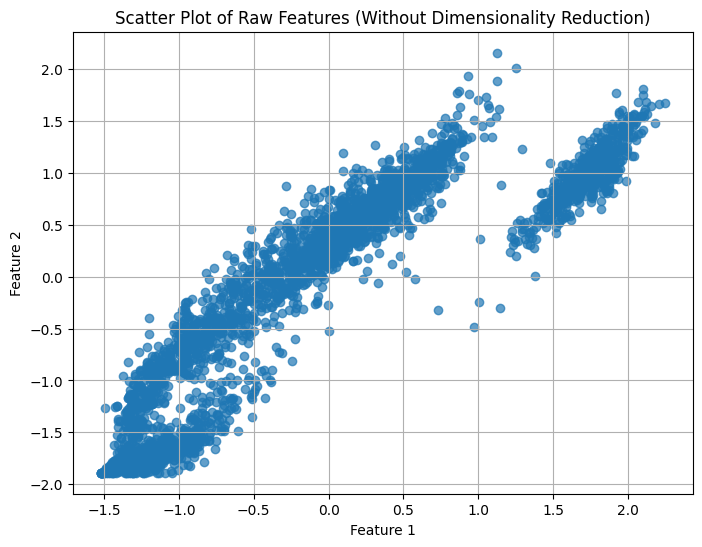

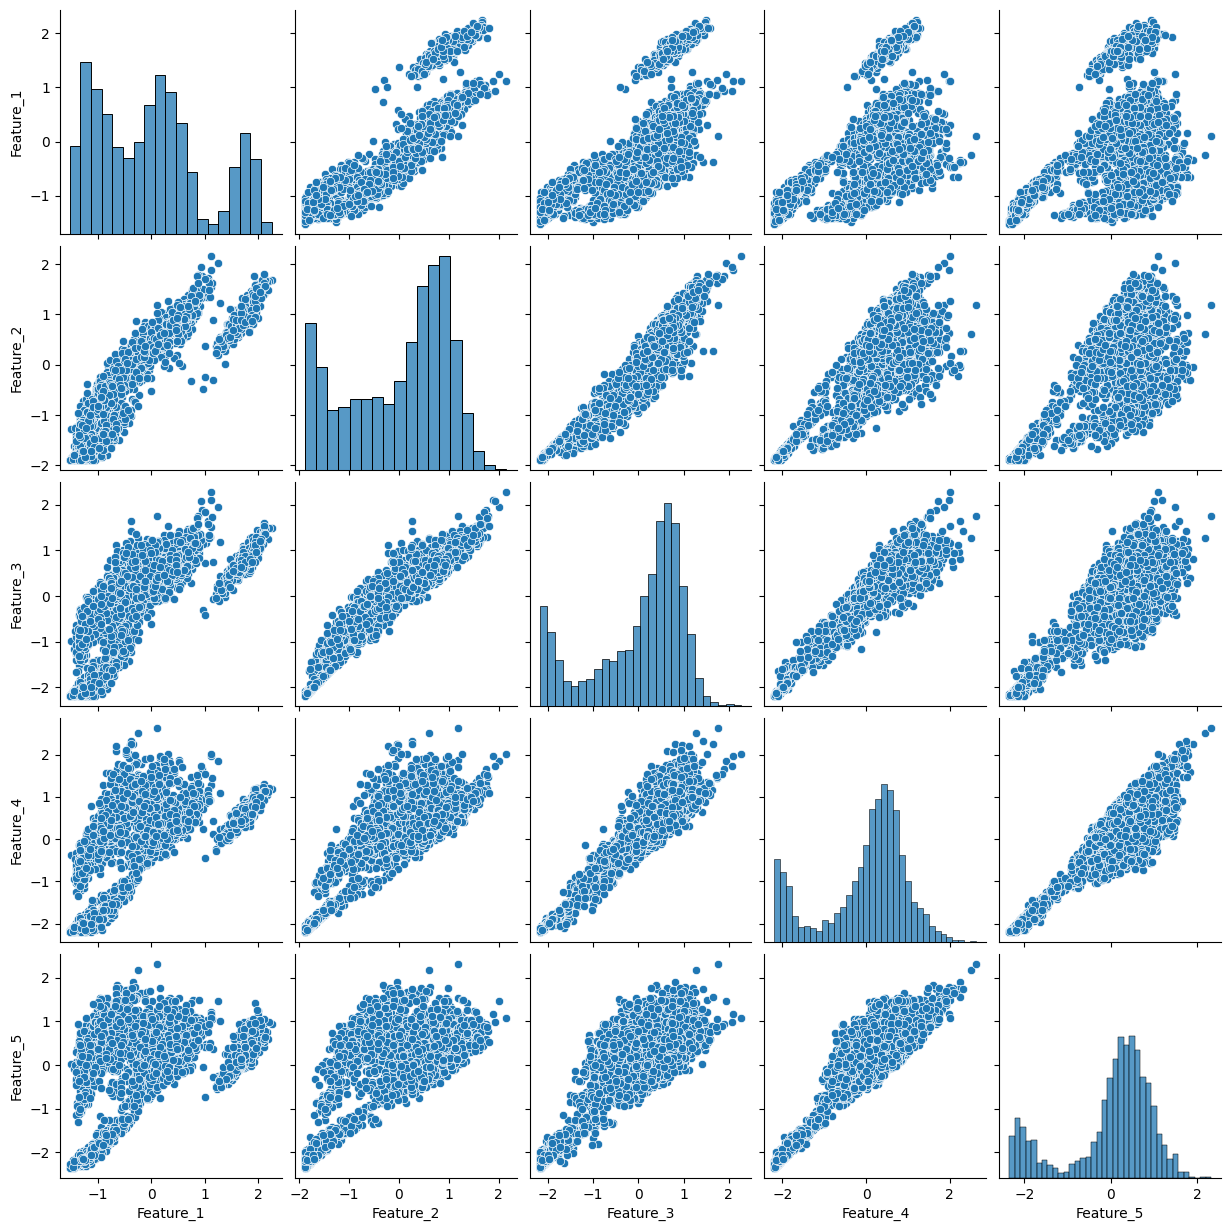

In [ ]:
# Use the scaled features DataFrame and select the first 5 columns
df = pd.DataFrame(features_scaled[:, :5], columns=[f"Feature_{i}" for i in range(1,6)])

# Scatter plot (Attempt without dimensionality reduction)
plt.figure(figsize=(8,6))
plt.scatter(df['Feature_1'],df['Feature_2'],alpha=0.7)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Scatter Plot of Raw Features (Without Dimensionality Reduction)")
plt.grid(True)
plt.show()

# Pair plot (Only using first 5 features)
sns.pairplot(df)
plt.show()

### Why is dimensionality reduction important?
(*Document any challenges/errors from the above experiments.*)

Challenges:
1. TOO MANY PLOTS/FEATURES: We only got to see a few summarized features. Imagine trying to go through each one of them thoroughly to find any meaningful relationships.

2. We miss out on any information that has to deal with time. Like frequency.

3. Without any reduction, it's close to impossible for me to see any clustering/groups or hints that tell me about categories.

So why?

Dimensionality reduction helps project this data on 3d (and 2d) and still keep some of that variance or data shape (clustering) as much as possible. I may lose some data, but the most important can be retained and get rid of the noise(less important)

Processing Mel Spectrograms:   0%|          | 0/3000 [00:00<?, ?it/s]

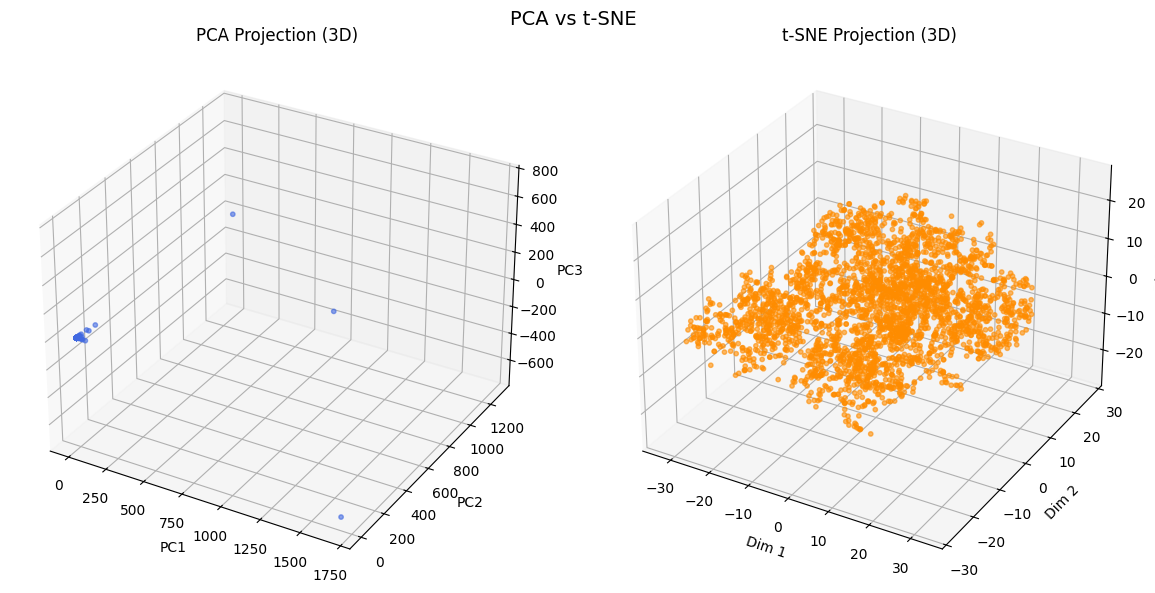

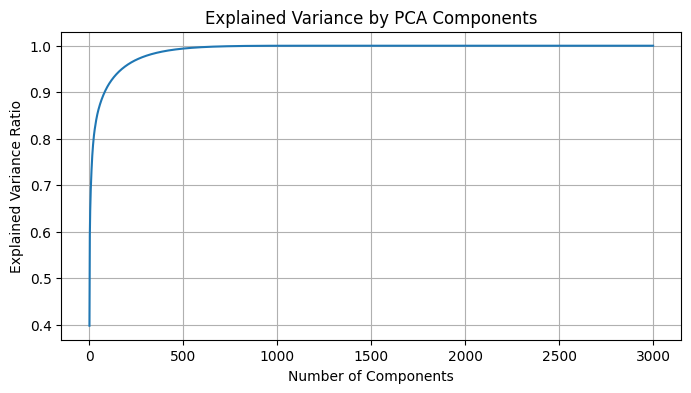

Explained variance ratio for first 3 components: 0.59223986


In [56]:
#create matrix
fixed_frames = 128
fixed_mels = features[0].shape[0]  # usually 128 Mel bands

#Pad or crop each mel spectrogram
def pad_or_crop(mel, target_frames):
    if mel.shape[1] < target_frames:
        # Pad with zeros
        pad_width = target_frames - mel.shape[1]
        return np.pad(mel, ((0,0), (0, pad_width)), mode='constant')
    else:
        # Crop
        return mel[:, :target_frames]

# Apply padding
X= np.array([pad_or_crop(librosa.feature.melspectrogram(y=librosa.load(wav_files[i], sr=None)[0], sr=librosa.load(wav_files[i], sr=None)[1], n_mels=128, n_fft=1024), fixed_frames).flatten() for i in tqdm(range(len(wav_files)), desc="Processing Mel Spectrograms")])

#normalize data before pca
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(X)

# Apply PCA (3 components)
pca = PCA(n_components=3)
features_pca = pca.fit_transform(X_scaled)

# 3D Visualization goes here
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.scatter(features_pca[:, 0], features_pca[:, 1], features_pca[:, 2], c='royalblue', alpha=0.6, s=10)
ax1.set_title("PCA Projection (3D)")
ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")
ax1.set_zlabel("PC3")

# Apply t-SNE (3 components)
tsne = TSNE(n_components=3, random_state=42)
features_tsne = tsne.fit_transform(X_scaled)

# 3D Visualization goes here
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.scatter(features_tsne[:, 0], features_tsne[:, 1], features_tsne[:, 2], c='darkorange', alpha=0.6, s=10)
ax2.set_title("t-SNE Projection (3D)")
ax2.set_xlabel("Dim 1")
ax2.set_ylabel("Dim 2")
ax2.set_zlabel("Dim 3")

plt.suptitle("PCA vs t-SNE", fontsize=14)
plt.tight_layout()
plt.show()

# Calculate and plot explained variance
pca_full = PCA()
pca_full.fit(X_scaled)

plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.show()

print("Explained variance ratio for first 3 components:", pca.explained_variance_ratio_.sum())

### Which method (PCA or t-SNE) provides better separability of clusters and why?
(*Write based on your visualizations.*)

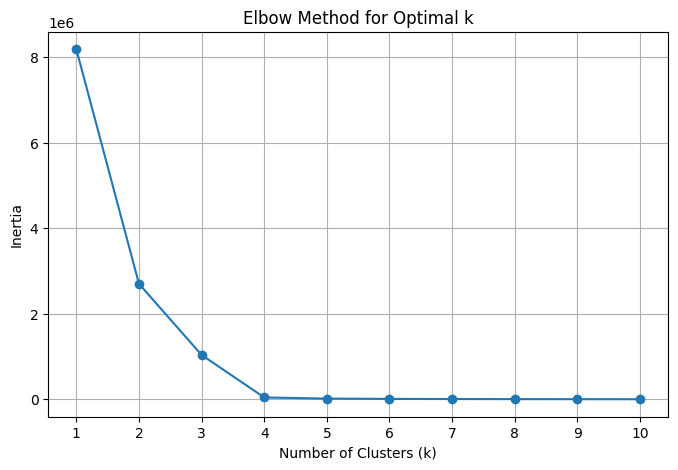

In [ ]:
# Optimize number of clusters using Elbow Method
from sklearn.cluster import KMeans

# Use PCA-reduced data for clustering
features_array = features_pca

inertia = []
# Test a range of cluster numbers (e.g., 1 to 10)
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # Added n_init to suppress warning
    kmeans.fit(features_array)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.xticks(k_range)
plt.grid(True)
plt.show()

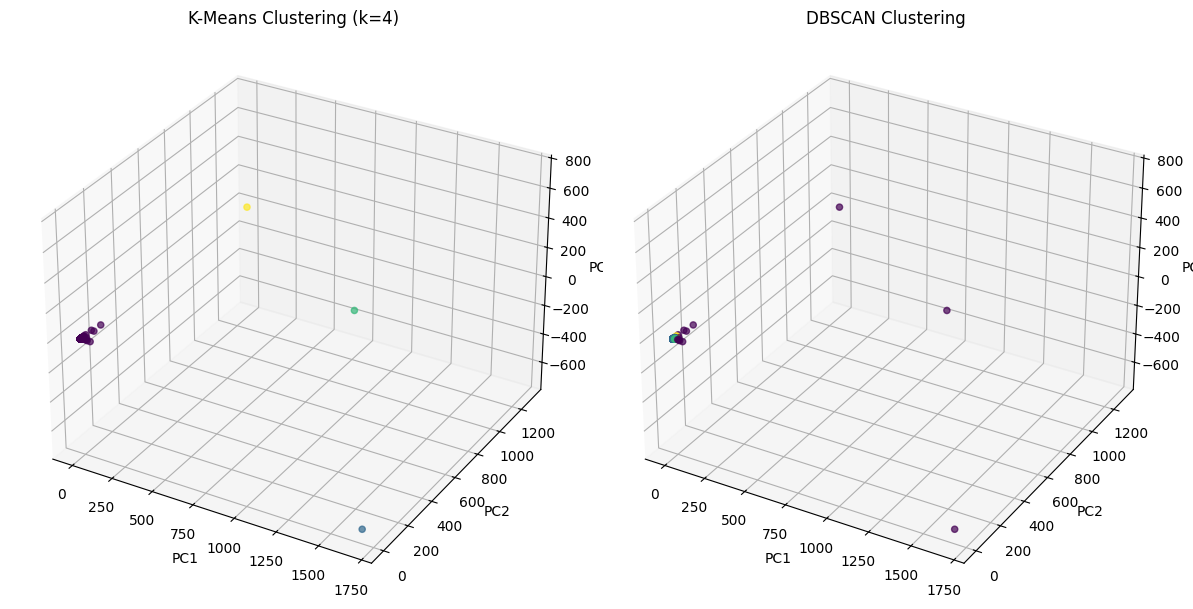

In [ ]:
# Select optimal K based on elbow method (e.g., k=3)
optimal_k = 4 # Based on the elbow method plot
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10) # Added n_init
kmeans_labels = kmeans.fit_predict(features_array)

# Apply DBSCAN
# You might need to adjust eps and min_samples based on your data
dbscan = DBSCAN(eps=5, min_samples=3)
dbscan_labels = dbscan.fit_predict(features_array)

# Scatter Plot for K-Means Clusters
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.scatter(features_array[:, 0], features_array[:, 1], features_array[:, 2], c=kmeans_labels, cmap='viridis', alpha=0.7)
ax1.set_title(f"K-Means Clustering (k={optimal_k})")
ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")
ax1.set_zlabel("PC3")

# Scatter Plot for DBSCAN Clusters
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.scatter(features_array[:, 0], features_array[:, 1], features_array[:, 2], c=dbscan_labels, cmap='viridis', alpha=0.7)
ax2.set_title("DBSCAN Clustering")
ax2.set_xlabel("PC1")
ax2.set_ylabel("PC2")
ax2.set_zlabel("PC3")

plt.tight_layout()
plt.show()

In [ ]:

# Evaluate clustering
kmeans_silhouette = silhouette_score(features_array, kmeans_labels)
kmeans_db_index = davies_bouldin_score(features_array, kmeans_labels)

if len(set(dbscan_labels)) > 1:
    dbscan_silhouette = silhouette_score(features_array, dbscan_labels)
    dbscan_db_index = davies_bouldin_score(features_array, dbscan_labels)
else:
    dbscan_silhouette = None
    dbscan_db_index = None

print(f"K-Means - Silhouette Score: {kmeans_silhouette:.4f}, Davies-Bouldin Index: {kmeans_db_index:.4f}")
if dbscan_silhouette is not None:
    print(f"DBSCAN - Silhouette Score: {dbscan_silhouette:.4f}, Davies-Bouldin Index: {dbscan_db_index:.4f}")
else:
    print("DBSCAN failed to form meaningful clusters.")


K-Means - Silhouette Score: 0.9984, Davies-Bouldin Index: 0.0004
DBSCAN - Silhouette Score: 0.9627, Davies-Bouldin Index: 1.8211


### Discuss the results (max 5 lines)
(*Compare K-Means and DBSCAN performance based on the outputs.*)

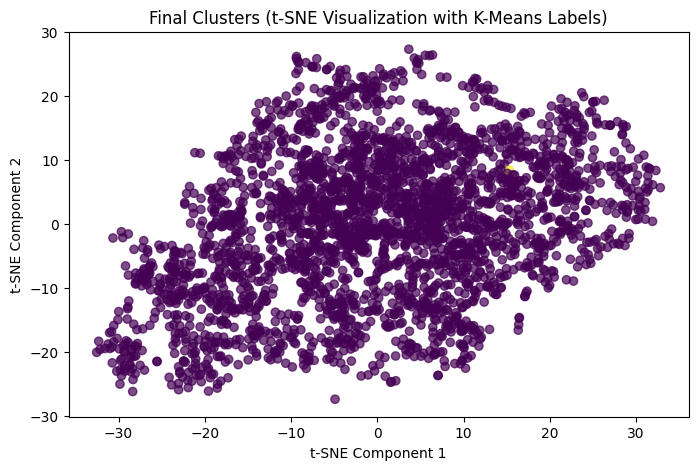

In [ ]:

# Final visualization using t-SNE
plt.figure(figsize=(8, 5))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Final Clusters (t-SNE Visualization with K-Means Labels)")
plt.show()


### Final Analysis
- Explain why dimensionality reduction helped (or didn't) in clustering.
- Justify why certain clustering methods worked better.
- Relate findings to real-world clustering challenges.